# Lab 04 &mdash; Parametric inference, part 2

## Roadmap

* [Confidence intervals for the sample mean with t distribution](#Confidence-intervals-for-the-sample-mean-with-tt-distribution)
* [Hypothesis testing for one-sample mean with T test](#Hypothesis-testing-for-one-sample-mean-with-t-test)
* [Computing the power of a test](#Computing-the-power-of-a-test)
* [Correcting for multiple tests](#Correcting-for-multiple-tests)
* [Hypothesis testing for two-sample mean](#Hypothesis-testing-for-two-sample-mean)
    * [Paired observations](#Paired-observations)
    * [Independent (unpaired) observations](#Independent-(unpaired)-observations)

## Confidence intervals for the sample mean with t distribution
* As for the Z confidence interval for the proportion, we can compute _t_-confidence intervals for the sample mean (unknown $\sigma$) both manually and automatically
* Recall the interval is given by: $\bar{x} \pm t_{\alpha/2} SE$, where $SE=s/\sqrt{n}$, $s$ is the sample stdev, and $t_{\alpha/2}$ is the critical value of the $t$ distribution
* The t-distribution is available in `scipy.stats` as the continuous RV class `t(df)`, where the argument `df` is the degrees of freedom
* Let's compute a CI for the mean age of a victim from a sample of the London murders dataset

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the csv file and store it into pd dataframe
# df_murders = pd.read_csv("https://personal.rhul.ac.uk/ufac/002/CS5970/data/london_murders.csv")
df_murders = pd.read_csv("london_murders.csv")
n = 100
# draw a random sample of size 100
df_murders_sample = df_murders.sample(n)

alpha = 0.05
# compute sample mean and st. err
mean_age = np.mean(df_murders_sample.age)
# IMPORTANT: by default, the number of degrees of freedom in the sample variance are n, 
# not n-1. The ddof parameter tells us how many fewer dof we have (in our case n-1, so 1)
SE_age = np.std(df_murders_sample.age, ddof=1)/np.sqrt(n)
print('Mean age is: '+str(mean_age))

Mean age is: 32.9


In [3]:
# to compute CI manually, first derive the critical t score at alpha/2
# which corresponds to the t value t_alpha_half s.t. P(T>=t_alpha_half)=alpha/2
# we know how to derive this with the ppf/inverse CDF of the t distribution with n-1 DoF
# (i.e. the continuous RV stats.t(n-1))
t_alpha_half = stats.t(n-1).ppf(1-alpha/2)
# or alternatively
#t_alpha_half = -stats.t(n-1).ppf(alpha/2)

# then compute the CI as
ci_mean_age = mean_age + SE_age*t_alpha_half*np.array([-1,1])
print('CI for mean age is: '+str(ci_mean_age))

CI for mean age is: [29.59086794 36.20913206]


* `statsmodels` provides an "automatic" method to compute t-confidence intervals. 
* it is a bit more elaborate than `zconfint` (see lab 03)
    * it requires to create first a summary statistic object (class `DescrStatsW` of module `stats`)
    * the interval is then computed on said object by invoking `tconfint_mean(self, alpha=0.05, alternative="two-sided")` function
    * see https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html for a list of attributes and functions of `DescrStatsW`

In [4]:
# create summary statistic object with statsmodels
age_stats = sm.stats.DescrStatsW(df_murders_sample.age)
age_stats.tconfint_mean(alpha=alpha)

(29.59086794414032, 36.209132055859676)

## Hypothesis testing for one-sample mean with T test

* We now want to perform HT for the mean age, using the T-test
* Consider the same example of Lab 3 (where we used the Z test instead)
* Assume that previous studies found that the mean age of a victim in London is 30. So $H_0: \mu = 30$.
* We want to test whether our data is consistent with $H_0$ with a two-sided T-test. So $H_a: \mu \neq 30$
    * I.e., if the observed mean is significantly higher or lower the null value
* Let's manually compute the test statistic ($\frac{\bar{x}-\mu_0}{(s/\sqrt{n})}$) and the p-value w.r.t. the sampling distribution under $H_0$ (t distribution with $n-1$ DoF)


In [5]:
# test statistic
mu_0 = 30
t_stat = (mean_age - mu_0)/SE_age
print('test statistic: '+str(t_stat))
# sampling distribution under H0
h0_dist = stats.t(n-1)

# compute p-value for two-sided test
left_p_val = h0_dist.cdf(t_stat) # P(t<=t_stat)
right_p_val = 1-h0_dist.cdf(t_stat) # P(t>=t_stat)
p_val = 2*np.min([left_p_val,right_p_val])
print('p value: '+str(p_val))

test statistic: 1.7388937830951232
p value: 0.08516200563203258


* To perform the test automatically, we can use the function `ttest_1samp` of `scipy.stats`. 
* The function takes in input:
    * the sample observations &mdash; argument `a` 
    * the null value &mdash; argument `popmean` 
* and returns the t-statistic and corresponding p-value for a 2-sided test
    * if we want the p-value for the corresponding one-sided test, just divide it by two

In [6]:
# perform test automatically with scipy.stats
t_test_result = stats.ttest_1samp(a=df_murders_sample.age, popmean=mu_0, axis=0)
print('test statistic: '+str(t_test_result.statistic))
print('p value: '+str(t_test_result.pvalue))

test statistic: 1.7388937830951232
p value: 0.0851620056320326


`statsmodels` also provides an automatic method, via function `ttest_mean` of class `DescrStatsW` which takes two arguments:
* `value`, the null value
* `alternative`, the direction of the alternative hypothesis (`'two-sided’` (default), `'larger’`, or `'smaller’`)

In [7]:
# perform test automatically with statsmodels
# we can re-use our DescrStatsW object age_stats defined above
tstat_sm, pvalue_sm, df = age_stats.ttest_mean(value=mu_0,alternative='two-sided')
print('test statistic: '+str(tstat_sm))
print('p value: '+str(pvalue_sm))

test statistic: 1.7388937830951225
p value: 0.08516200563203272


## Computing the power of a test
* Recall that the power of a test is $1-\beta$, i.e., the probability of correctly rejecting $H_0$, where $\beta$ is the probability of a type 2 error (wrongly fail to reject $H_0$, aka false negative)
* To compute the power, we need to assume a true value for the population parameter ($H_0$ is false)
* We will compute power manually, and then show a function from `statsmodels`

* Consider the above two-sided t-test for the mean age ($H_0: \mu=\mu_0=30$, $H_a: \mu \neq \mu_0=30$).
* Let's assume the true mean is $\theta$. 
* Then, $1- \beta$ is the probability of correctly rejecting $H_0$, i.e., the probability (assuming $\mu=\theta$) that the test statistic falls in either critical region of the $H_0$ distribution.
* We saw that, for a two-sided test, power corresponds to $P(t+\delta\geq t_{\alpha/2}) + P(t+\delta\leq -t_{\alpha/2})$, which can be computed as $1-F(t_{\alpha/2}-\delta)+F(-t_{\alpha/2}-\delta)$, with $F$ being the CDF of the t-distribution with $n-1$ DoF, and $\delta=\frac{\theta-\mu_0}{s/\sqrt{n}}$
    * $\frac{\theta-\mu_0}{s}$ is called Cohen's effect size

In [8]:
# for convenience, we can wrap our definition in a function
def two_sided_t_power(mu_0, mu_true, sample_std, n, alpha):
    # critical value of test under H_0
    t_alpha_2 = stats.t(n-1).ppf(1-alpha/2)
    delta = (mu_true-mu_0)/(sample_std/np.sqrt(n))
    return 1-stats.t(n-1).cdf(tstd
# equivalent to setting the loc  parameter of t distribution to delta as follows
# return 1-stats.t(n-1,loc=delta).cdf(t_alpha_2)+stats.t(n-1,loc=delta).cdf(-t_alpha_2)

sample_std = np.std(df_murders_sample.age, ddof=1)
n = df_murders_sample.age.size
alpha = 0.05
# assume the true value is 32, print the power value
two_sided_t_power(30, 32, sample_std, n, alpha)

0.21814262998750977

* Below we show how the power of our t-test changes for different assumed true values
* The resulting plot is called ___power curve___, where we have on x-axis the assumed true values, and on the y-axis the corresponding power

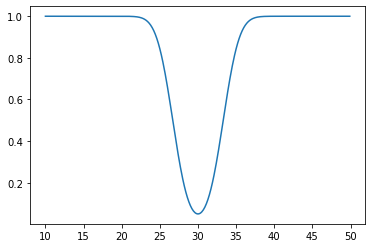

In [9]:
# now let's plot a power curve for different assumed true values (a range between 10 and 50)
mu_trues = np.arange(10, 50, 0.1)
# we need to vectorize our function so that it works for arrays
two_sided_t_power_vec = np.vectorize(two_sided_t_power)
# plot on the x-axis the assumed true values, on the y-axis the corresponding power
plt.plot(mu_trues, two_sided_t_power_vec(30, mu_trues, sample_std, n, alpha))
plt.show()

* The `statsmodels` package has a function that can automatically compute the power of a t-test, called `tt_solve_power` (see also https://www.statsmodels.org/dev/generated/statsmodels.stats.power.tt_solve_power.html) 
* In particular, it takes _all but one_ of 
    * (Cohen's) effect size, `effect_size`
    * sample size, `nobs`
    * $\alpha$, `alpha`
    * $1-\beta$, `power`
and automatically computes the missing parameter.
* note that the power values will be slightly different from our implementation (`statsmodels` use the _non-central t distribution_ to compute probabilities, rather than a shifted t distribution like we do (the non-central t is the correct one but I didn't want to put too much meat on your plates))
* also note that sometimes `tt_solve_power` can fail and throw an exception, so it's not your fault if that happens :)

In [10]:
# let's compute the power for theta=32 of the above test
# we need to compute cohen's effect size on our own though
c_eff_size = (32-30)/sample_std
sm.stats.tt_solve_power(effect_size=c_eff_size, nobs=n, alpha=alpha, alternative='two-sided')

0.22077917765129249

With `tt_solve_power` we can do more interesting things. For instance, we can compute what's the required value of $n$ to obtain an arbitrary power value and for arbitrary effect size and $\alpha$

In [11]:
# let's see what the required n to obtain power=90% with effect size of 0.5
# n is integer, so we take the ceiling
int(np.ceil(sm.stats.tt_solve_power(effect_size=0.5, power=0.9, alpha=0.05, alternative='two-sided')))

44

## Correcting for multiple tests
* We saw that with multiple tests, we need to correct the significance of the individual tests if we desire a given overall $\alpha$ (aka family-wise error rate)
* `statsmodels` provides a function `multipletests` for correcting the p-values of multiple tests a posteriori, based on a variety of methods (see https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html for more details)
* it takes in input an array of p-values (one p-value per test), the desired overall significance $\alpha$, and the kind of method to use, and returns, 
    * for each p-value/test, whether or that can be rejected for the given $\alpha$
    * corrected p-values
    * corrected $\alpha$s to use in individual tests 

In [12]:
# here we have three tests, with p-values 0.1, 0.01, and 0.02, respectively
# and we use the bonferroni method to correct these p-values
rejected, correct_pvals, _, correct_alpha_bonf = sm.stats.multipletests([0.1,0.01,0.02], alpha=0.05, method='bonferroni')
print("tests rejected? "+str(rejected))
print("corrected p-values (which we can check against non-corrected alpha) "+str(correct_pvals))
print("Bonferroni-based correction for alpha (which we can check against non-corrected p-values) "+str(correct_alpha_bonf))

tests rejected? [False  True False]
corrected p-values (which we can check against non-corrected alpha) [0.3  0.03 0.06]
Bonferroni-based correction for alpha (which we can check against non-corrected p-values) 0.016666666666666666


## Hypothesis testing for two-sample mean

### Paired observations
* As we discussed in the lectures, with paired observations, we can directly compute pairwise differences and do inference directly on those, as in a regular 1-sample test
* let's see a quick example using the CDC BRFSS survey dataset, where we have, for each individual, two variables, weight and desired weight. 
* We can do a paired T test on the mean difference between the two, and compute corresponding confidence intervals

In [13]:
# load the CDC BRFSS survey dataset and take a random sample of 50 observations
df_cdc = pd.read_csv("cdc.csv")
n_cdc = 50
df_cdc_sample = df_cdc.sample(n_cdc)
# compute the pairwise differences between weight and wtdesire
w_diff = df_cdc_sample.weight-df_cdc_sample.wtdesire

In [14]:
# let's use statsmodels for this. 
# recall we need to create first a summary statistic object
w_diff_stats = sm.stats.DescrStatsW(w_diff)

# test the null hypothesis that there is no difference (i.e., mean difference = 0)
tstat_wdiff, pvalue_wdiff, _ = w_diff_stats.ttest_mean(value=0, alternative='two-sided')
print('p-value is: '+str(pvalue_wdiff))

# and we can compute a (1-alpha)-confidence interval for the mean difference
alpha = 0.05
print(w_diff_stats.tconfint_mean(alpha=alpha))

p-value is: 6.261765342962921e-06
(11.130862318573932, 25.78913768142607)


### Independent (unpaired) observations
We will now look into unpaired two-sample T tests, to evaluate the differences of two sample means. 
* `statsmodels.stats` has a convenient class called `CompareMeans` (see https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.CompareMeans.html). `CompareMeans` takes in input two instances of `DescrStatsW` (see above) representing the two samples
* This class includes function `ttest_ind` for performing unpaired two-sample T tests, aka Welch's T test (`ind` stands for independent samples, i.e., unpaired) &mdash; `scipy.stats` has a similar function but supports only two-sided tests
    * `ttest_ind` takes in input the parameter `usevar`, which can be equal to `pooled` (in case the variances of the two populations are the same), or `unequal` (otherwise, i.e., as in the Welch T test)
* Let's see it in action. Using the london murders dataset, let's establish whether there is a significant difference between the ages of victims in 2007 and 2010.

In [15]:
# select a sample of 50 individuals from 2007 and 2010 victims
n = 50
sample_2007 = df_murders[df_murders.year==2007].sample(n)
sample_2010 = df_murders[df_murders.year==2010].sample(n)
# print the sample means, just for curiosity
print("Mean victim age in 2007 is " + str(np.mean(sample_2007.age)))
print("Mean victim age in 2010 is " + str(np.mean(sample_2010.age)))

Mean victim age in 2007 is 33.22
Mean victim age in 2010 is 35.96


In [16]:
# create the two DescrStatsW instances
age_2007_stats = sm.stats.DescrStatsW(sample_2007.age)
age_2010_stats = sm.stats.DescrStatsW(sample_2010.age)
# create a CompareMeans instance with the two samples above
comp_means_instance = sm.stats.CompareMeans(age_2007_stats,age_2010_stats)

# invoke the ttest_ind function
# "direction" of the test is "two-sided" by default, so we don't specify it here
# you can also set a null value for the hypothesized true difference of means, which by default is zero
# it returns the t statistic, p-value and df (recall, df for Welch test is not trivial)
tstat, pval, df  = comp_means_instance.ttest_ind(usevar='unequal')
print('Value of T statistic ' + str(tstat))
print('P-value ' + str(pval))
print('Degrees of freedom ' + str(df))

Value of T statistic -0.7119885894585983
P-value 0.4782202560154317
Degrees of freedom 94.80656199292021


The same `CompareMeans` instance can be used to derive a confidence interval for the difference of the two means with the function `tconfint_diff`

In [17]:
alpha = 0.01
comp_means_instance.tconfint_diff(alpha=alpha,usevar='unequal')

(-12.856170353851061, 7.376170353851057)

* `statsmodels` has a function, `tt_ind_solve_power`, for computing power/effect size/etc also for two-sample tests
    * the equivalent of `tt_solve_power`. 
* In particular, it takes all but one of: effect size, size of sample 1 $n_1$, `ratio`, $\alpha$, $1-\beta$, and automatically computes the missing parameter. 
    * size of sample 2 is derived from $n_1$ and `ratio` as $n_2 = n_1 \cdot$`ratio`

* note that this implementation only supports pooled variance, i.e., it works under the assumption that the two populations have same variance
* and so, the function expects to work with Cohen's effect sizes defined as $d=\frac{\theta}{s_p}$, where $\theta$ is the assumed true value for $\mu_1-\mu_2$ and $s^2_p$ is the so-called pooled variance (estimation of common variance of the two populations) and is defined as (see also https://en.wikipedia.org/wiki/Pooled_variance): 
$$s^2_p=\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}$$
    * we didn't see this during the lectures, so take it as it is

In [18]:
# let's compute now the value of Cohen's effect size required for a 1-sided test 
# to achieve a power of 95%, with alpha = 0.05, and current n1 and ratio, 
n_2007 = sample_2007.shape[0]
n_2010 = sample_2010.shape[0]
cohens_d = sm.stats.tt_ind_solve_power(effect_size=None, nobs1=n_2007, alpha=0.05, 
                                  power=0.95, ratio=n_2010/n_2007, alternative='smaller')

print("effect size: "+str(cohens_d))
# in this case d = (theta="assumed true value for mu_1-mu_2")/(pooled standard deviation)
# if we want to derive the corresponding value of theta, 
# we need to compute the pooled standard deviation and multiply it to d
pooled_variance = ((n_2007-1)*np.var(sample_2007.age, ddof=1)+(n_2010-1)*np.var(sample_2010.age, ddof=1))/(n_2007+n_2010-2)
print("corresponding true mu_1-mu_2 is "+str(cohens_d*np.sqrt(pooled_variance)))

effect size: -0.6625416123406963
corresponding true mu_1-mu_2 is -12.748547130466838
